In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import scipy.stats as stats
import emcee
import numpy.linalg as la
import matplotlib.pyplot as plt

In [2]:
file_name_peaks_Maps05=(np.array(np.loadtxt('/Users/vajani/Desktop/CFIS/list_kappa_z05.txt', usecols=0,dtype=np.str)))

In [3]:
#extract parameters values from file name
def takes_params(fn):
    
    mnv=float(fn.split('convergence_gal_mnv')[1].split('_')[0])
    Om=float(fn.split('om')[1].split('_')[0])
    As=float(fn.split('As')[1].split('_')[0])

    return mnv,Om,As

params = np.array([takes_params(f) for f in file_name_peaks_Maps05])

In [4]:
#load peaks distribution for simulations
Peaks_Maps05=np.array([np.load('/Users/vajani/Desktop/CFIS/Peaks_kappa_2arcmin_z05/%s'%(fn), mmap_mode='r') for fn in file_name_peaks_Maps05])[:,:,9:]

In [5]:
print(np.shape(Peaks_Maps05))

(99, 10000, 32)


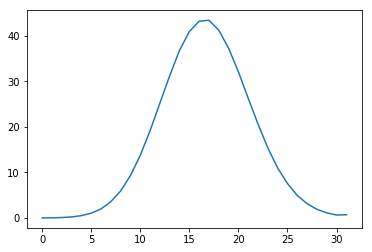

In [6]:
plt.plot(np.mean(Peaks_Maps05[40,:,:],axis=0))

In [7]:
#load peaks distribution for data
fid_kappa=np.load('fiducial_peaks_Ksmoothed_single_gaussian.npy', mmap_mode='r')[9:]

In [8]:
print(np.shape(fid_kappa))

(32,)


In [9]:
#interpolation with Gaussian Processes
scaling=[]
gp_list=[]
gp_score=[]

for obs_bin in range(len(fid_kappa)):
    
    #means over the realisations for each bin looping over each cosmology
    obs_means=np.array([np.mean(obs_temp,axis=0)[obs_bin] for obs_temp in Peaks_Maps05])
    
    #sem over the realisations for each bin looping over each cosmology
    values_for_alpha=np.array([stats.sem(obs_temp,axis=0)[obs_bin] for obs_temp in Peaks_Maps05])
    
    #data scaling factor
    scaling.append(np.mean(obs_means))
    
    #scale the data values to avoid over-regularization
    obs_means /= scaling[-1]
    
    #scale the standard errors of the mean values to avoid over-regularization
    values_for_alpha /= scaling[-1]
    
    #define the kernel
    kernel = C(5.0, (1e-4, 1e4)) * RBF([3, 0.3, 5], (1e-4, 1e4))
    
    #instantiate the gaussian process
    gp = GaussianProcessRegressor(kernel=kernel,alpha=(values_for_alpha)**2,n_restarts_optimizer=50,normalize_y=True)
    
    gp.fit(params,obs_means)
    
    gp_list.append(gp)
    
    gp_score.append(gp.score(params,obs_means))

scaling_for_each_bin=np.array(scaling)

def GP_pred(x):

    pred_list=[]
    sigma_list=[]
    
    for gp in gp_list:
        
        pred,sigma=gp.predict(np.array(x).reshape(1,3),return_std=True)
        
        pred_list.append(pred[0])
        
        sigma_list.append(sigma[0])
    
    return np.array(pred_list * scaling_for_each_bin),\
                np.array(sigma_list * scaling_for_each_bin)

In [10]:
#load peaks to compute covariance matrix
cov_peaks_05=np.load('/Users/vajani/Desktop/CFIS/Peaks_kappa_2arcmin_z05/convergence_gal_mnv0.00000_om0.30000_As2.1000_peaks_2arcmin_z0.50_b041_kappa_smoothed_min_max_ngal_7.npy', mmap_mode='r')[:,9:]

87797.2933381439

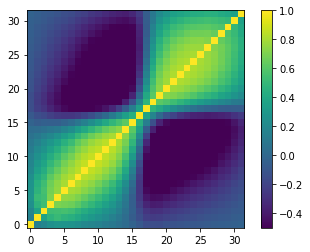

In [11]:
#plot correlation matrix
corr=np.corrcoef(cov_peaks_05.T)

plt.imshow(corr, origin='low', vmin=-0.5,vmax=1)
plt.colorbar()

cov=np.cov(cov_peaks_05.T)
la.cond(cov)

In [12]:
icov=la.inv(cov)

In [13]:
#MCMC
print('start the MCMC')

n_real=10000
n_bins=len(fid_kappa)

#correct for limited number of real (put then inside the likelihood)
norm=(n_real-n_bins-2)/(n_real-1)
print(norm)


def lnlike(theta):
 
    M_nu, Omega_m, A_s=theta
    
    obs_pred=GP_pred(theta)[0]

    lnlikelihood=-0.5*np.dot(np.dot((fid_kappa.reshape(len(fid_kappa),1)-obs_pred.reshape(len(fid_kappa),1)).T,icov),(fid_kappa.reshape(len(fid_kappa),1)-obs_pred.reshape(len(fid_kappa),1)))
    
    
    if M_nu<=0:
        return -np.inf
    
    return lnlikelihood

like_prova=lnlike([0.1,0.3,2.1])
print(like_prova)

M_nu_min = 0.06  # minimum from oscillation experiments
M_nu_max = np.max(params[:,0])
Omega_m_min = np.min(params[:,1])
Omega_m_max = np.max(params[:,1])
A_s_min = np.min(params[:,2])
A_s_max = np.max(params[:,2])


def lnprior(theta):
    """Ensure the sampler stays near computed simulations."""
    M_nu, Omega_m, A_s = theta
    if (M_nu_min < M_nu < M_nu_max and
            Omega_m_min < Omega_m < Omega_m_max and
            A_s_min < A_s < A_s_max):
        return 0.0
    return -np.inf


#posterior
def lnpost(theta):
        
    lp = lnprior(theta)
    if not np.isfinite(lp):
      return -np.inf
    
    return lp+lnlike(theta)

ndim, nwalkers = 3,200
pos = [[0.1, 0.3, 2.1]+1e-3*np.random.randn(ndim) for i in range(nwalkers)]

from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

from multiprocessing import Pool
import time
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost, pool=pool)
    start = time.time()
    sampler.run_mcmc(pos, 2500, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
 

samples = sampler.chain[:,200:, :].reshape((-1, ndim))

start the MCMC
0.9966996699669967
[[-295.76893148]]
8 CPUs


100%|██████████| 2500/2500 [09:42<00:00,  4.21it/s]

Multiprocessing took 582.3 seconds


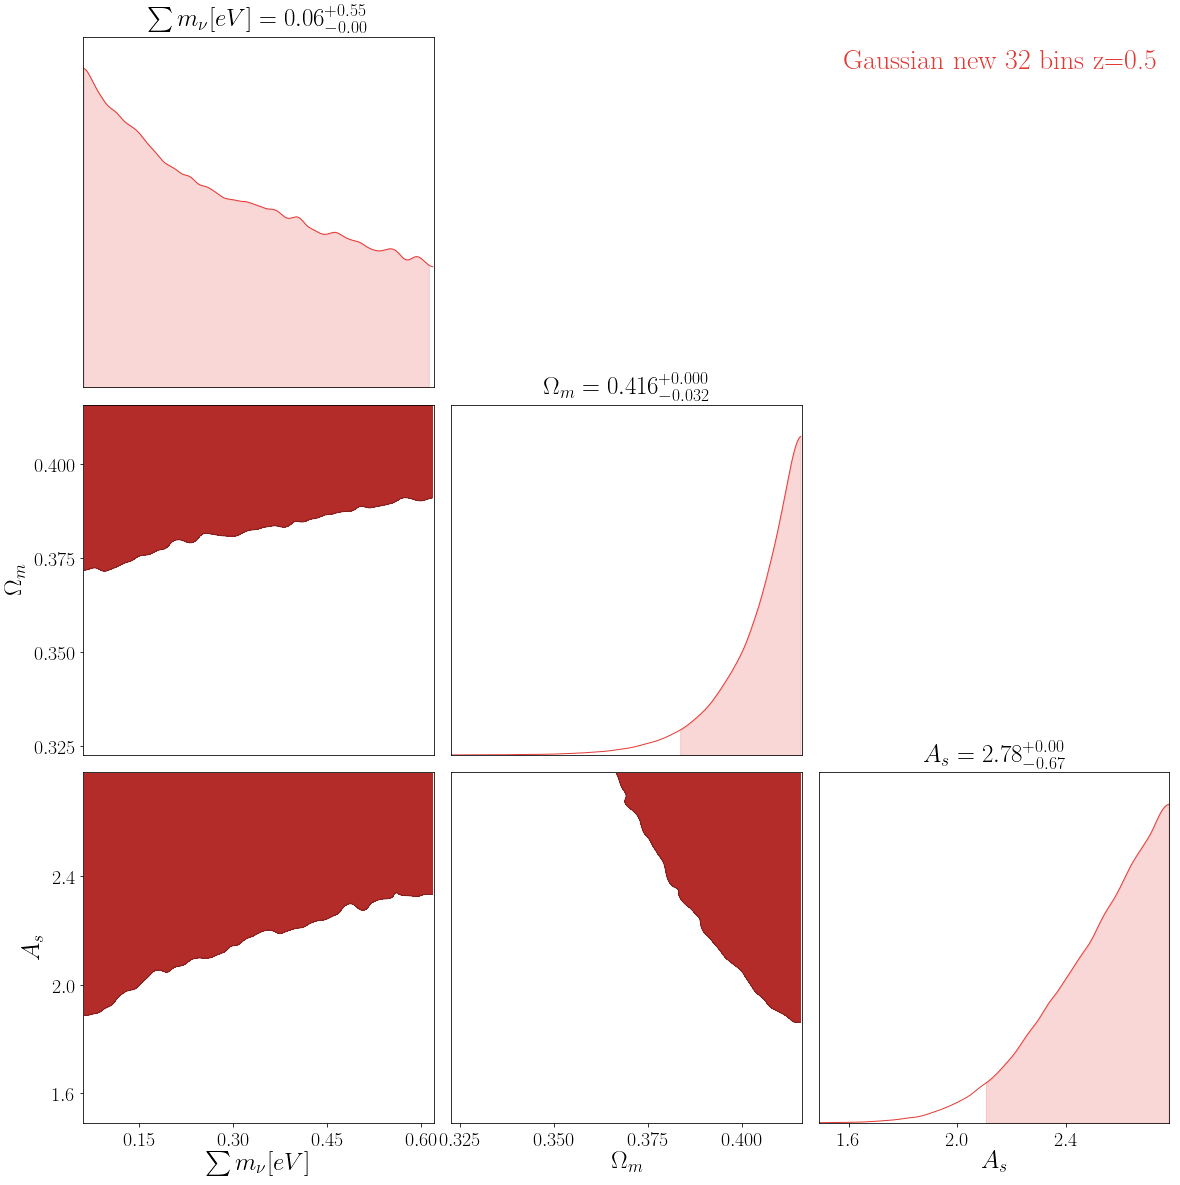

In [15]:
from chainconsumer import ChainConsumer
c = ChainConsumer()

c.add_chain(samples, parameters=[r"$\sum m_{\nu} [eV]$","$\Omega_m$", r"$A_s$"],zorder=1,name="Gaussian new 32 bins z=0.5")


c.configure(linestyles=["-", "-"],legend_kwargs={"loc": 0, "fontsize": 28},
            legend_color_text=True, colors=['r', 'b'],summary_area=0.955,sigmas=[2],diagonal_tick_labels=False, tick_font_size=20, label_font_size=25, max_ticks=4)
fig = c.plotter.plot(filename='prova.pdf',legend=True,figsize=1.5)
fig.set_size_inches(11+fig.get_size_inches())  